In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import credentials
import sqlconnector as sql
from functools import reduce
from tqdm.notebook import tqdm
import seaborn as sns


##### Install this before running the code

In [2]:
#pip install mysql-connector-python

##### Establish Connection through SQL connector


In [3]:
s = sql.sqlconnector(credentials.HOST,credentials.USER,credentials.PASSWORD,credentials.PORT,'product_mutual')

In [4]:
s.connect()

Connection Success


### Number of mututal fund products
Compute the total number of distinct mutual funds with weekly returns

In [5]:
query = """
select count(DISTINCT fund_id) as fund_num,statistic_date
from fund_weekly_risk 
where 
benchmark = 1
group by
statistic_date 
having 
statistic_date
between 
'2001-01-01' and '2022-12-10'
"""

In [6]:
fund_num = s.fetch(query)

In [138]:
fund_num.set_index('statistic_date',inplace=True)

Text(0.5, 1.0, 'Number of registered mutual fund products in China')

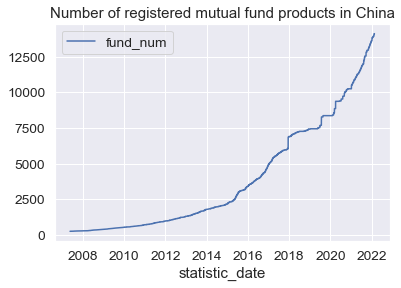

In [141]:
fund_num.rolling(500).max().plot(kind='line',label = 'Fund Number')
plt.title('Number of registered mutual fund products in China')


In [144]:
len(df_merged.columns)

436

### Fund Universe

In [8]:
fund_type_query = "select fund_type, count(*) as fund_num from fund_info where is_main_fund = 1 group by fund_type"

In [9]:
fund_type_count = s.fetch(fund_type_query)

In [10]:
fund_type_map ={'QDII基金':'QDII Fund','债券型基金':'Bond','其他基金':'other','混合型基金':'Blend','股票型基金':'equty','货币型基金':'currency'}

In [11]:
fund_type_count['fund_type'] = fund_type_count.fund_type.map(fund_type_map)

In [147]:
fund_type_count.sum()

fund_type    QDII FundBondotherBlendequtycurrency
fund_num                                     7316
dtype: object

Text(0.5, 1.0, 'Fund Strategy Types')

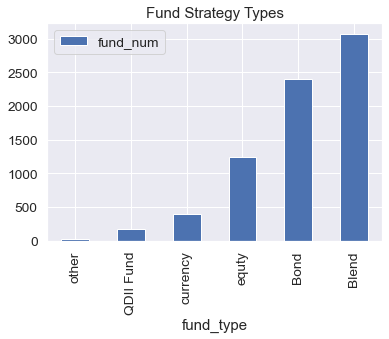

In [149]:
fund_type_count.sort_values('fund_num').plot(x='fund_type',y='fund_num',kind = 'bar')
plt.title('Fund Strategy Types')

##### select products that:
    - equity fund
    - have at least 2 years of history
    - is the parent product
    - is equity focused
    - use CSI300 index as benchmark

In [13]:
standard_query  = ("select * from {table} where statistic_date > '2017-01-01'"
"and `benchmark` = 1 and fund_id in"
" (select fund_id from fund_info where foundation_date < '2020-01-01' and is_main_fund = 1 "
"and fund_type = '股票型基金')")


### Fund Size

In [14]:
scale_query = ("SELECT fund_id, AVG(NULLIF(total_assets, 0)) as total_asset"
" FROM fund_balance" 
" GROUP BY fund_id")

In [15]:
fund_scale = s.fetch(scale_query)

In [150]:
print("There are {num} of funds".format(num = len(set(fund_scale.fund_id))))

There are 14117 of funds


In [17]:
fund_scale['total_asset'] = pd.to_numeric(fund_scale['total_asset'])


##### select funds with a total asset of at least 50 million RMB

In [18]:
fund_scale_selected = fund_scale[fund_scale.total_asset > 5e7]

### Feature Engineering

#### Perforamnce Features

In [21]:
fund_monthly_return =  s.fetch(standard_query.format(table ='fund_monthly_return'))

Unread result found
Retrying Connection...
Connection Success


In [22]:
fund_monthly_risk=  s.fetch(standard_query.format(table ='fund_monthly_risk'))

In [23]:
fund_monthly_risk_2 =  s.fetch(standard_query.format(table ='fund_monthly_risk2'))

In [24]:
fund_monthly_subsidiary=  s.fetch(standard_query.format(table ='fund_monthly_subsidiary'))

In [25]:
fund_monthly_subsidiary_2=  s.fetch(standard_query.format(table ='fund_monthly_subsidiary2'))

In [26]:
fund_monthly_subsidiary_3=  s.fetch(standard_query.format(table ='fund_monthly_subsidiary3'))

In [27]:
data_frames = [fund_monthly_return, fund_monthly_risk,fund_monthly_risk_2,fund_monthly_subsidiary,fund_monthly_subsidiary_2,fund_monthly_subsidiary_3]

In [28]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['statistic_date','fund_id'],
                                            how='outer',suffixes=('', '_drop')), data_frames)
df_merged.drop([col for col in df_merged.columns if 'drop' in col], axis=1, inplace=True)

In [29]:
df_merged = df_merged.fillna(value=np.nan)

In [30]:
df_merged = df_merged.loc[df_merged['fund_id'].isin(fund_scale_selected.fund_id)]

In [152]:
len(df_merged.columns) - 5

431

##### Total number of funds satisfying the requirement

In [31]:
df_merged.statistic_date = pd.to_datetime(df_merged.statistic_date)
len(set(df_merged.fund_id))

608

##### Fetch Fund returns, with Net Asset Value accounting for dividend payment and compute monthly data

In [32]:
return_query = ("select fund_id, statistic_date,added_nav from fund_nv "
"where fund_id = '{fund_id}' "
"and statistic_date > '2017-01-01'")


In [33]:
def get_returns(fund_id):
    df = s.fetch(return_query.format(fund_id = fund_id))
    df['statistic_date'] = pd.to_datetime(df['statistic_date'])
    df = df.set_index('statistic_date')
    df = df.resample('M').last()
    return df

In [34]:
fund_ids = list(set(df_merged.fund_id))

In [35]:
frames = [get_returns(id)['added_nav'] for id in tqdm(fund_ids)]

  0%|          | 0/608 [00:00<?, ?it/s]

In [36]:
df_ret = pd.concat(frames,axis=1)
df_ret.columns = fund_ids

In [37]:
for col in df_ret.columns:
    df_ret[col] = pd.to_numeric(df_ret[col])
df_ret = df_ret.pct_change().shift(-1)

In [38]:
df_merged['ret'] = df_merged.apply(lambda x: df_ret.loc[x.statistic_date,x.fund_id],axis=1)

#### Fundamental Features

#####  Fund Asset:  fund total asset data

In [39]:
asset_query = ("SELECT fund_id,statistic_date,total_assets"
" FROM fund_balance")

In [40]:
total_assets = s.fetch(asset_query)

In [41]:
total_assets['statistic_date'] = pd.to_datetime(total_assets['statistic_date'] )
total_assets['total_assets'] = pd.to_numeric(total_assets['total_assets'])
total_assets_pivoted = pd.pivot_table(data=total_assets,index=['statistic_date'],columns= ['fund_id'],values=['total_assets'])

In [42]:
total_assets_pivoted = total_assets_pivoted.reindex(df_ret.index).ffill()

In [43]:
df_merged['asset'] = df_merged.apply(lambda x: total_assets_pivoted.loc[x.statistic_date,('total_assets',x.fund_id)],axis=1)

#####  Flow Data 
Flow = Purchase Amount - Redemption Amount


In [44]:
scale_query = ("SELECT fund_id,statistic_date,purchase_amount, redemption_amount "
" FROM fund_asset_scale")

In [45]:
flow = s.fetch(scale_query)

In [46]:
flow['statistic_date'] = pd.to_datetime(flow['statistic_date'] )
flow['purchase_amount'] = pd.to_numeric(flow['purchase_amount'])
flow['redemption_amount'] = pd.to_numeric(flow['redemption_amount'])
flow['flow'] = flow['purchase_amount'] - flow['redemption_amount']


In [47]:
flow_pivoted = pd.pivot_table(data=flow,index=['statistic_date'],columns= ['fund_id'],values=['flow'])

In [48]:
flow_pivoted = flow_pivoted.reindex(df_ret.index).ffill()

In [49]:
df_merged['flow'] = df_merged.apply(lambda x: flow_pivoted.loc[x.statistic_date,('flow',x.fund_id)] if x.fund_id in flow_pivoted.flow.columns else 0,axis=1)

##### Fund Fee 
Fund management fee

In [50]:
fee_query = ("select fund_id, fee, min(tmstamp) from fund_fee_data "
"where limit_name ='管理费' "
"and fund_id in ( "
"select fund_id from fund_info where foundation_date < '2020-01-01' and is_main_fund = 1 "
"and fund_type = '股票型基金') "
"group by fund_id")

In [51]:
fee =  s.fetch(fee_query).set_index('fund_id')

In [52]:
df_merged['fee'] = df_merged.apply(lambda x: fee.loc[x.fund_id]['fee'],axis=1)

##### Operational Features 

In [160]:
operations_query = ("SELECT *"
" FROM fund_balance")

In [162]:
operations= s.fetch(operations_query)

MySQL Connection not available.
Retrying Connection...
Connection Success


In [179]:
operations.statistic_date = pd.to_datetime(operations.statistic_date)

In [176]:
exempt = ['fund_id', 'fund_name', 'statistic_date', 'data_source', 'entry_time','update_time']

In [220]:
for col in operations.columns:
    if col not in exempt:
        print('Process ',col)
        df_pivoted = pd.pivot_table(data=operations,index=['statistic_date'],columns= ['fund_id'],values=[col])
        df_pivoted = df_pivoted.reindex(df_ret.index).ffill()
        df_merged[col] = df_merged.apply(lambda x: df_pivoted.loc[x.statistic_date,(col,x.fund_id)] if x.fund_id in df_pivoted[col].columns else np.nan,axis=1)

Process  bank_deposit
Process  provision_settlement_fund
Process  refundable_deposits
Process  transaction_monetary_assets
Process  stock_income
Process  bonds_income
Process  abs_income
Process  derivatives_income
Process  buying_back_income
Process  securities_settlement_receivable
Process  interest_revenue
Process  dividend_income
Process  subscription_receivable
Process  other_assets
Process  total_assets
Process  short_term_loan
Process  transaction_financial_liabilities
Process  derivative_financial_liabilities
Process  sold_repurchase_payment
Process  securities_settlement_payable
Process  redemption_payable
Process  org_compensation_payable
Process  trustee_payable
Process  sales_service_payable
Process  transaction_payable
Process  tax_payable
Process  interest_payable
Process  profit_payable
Process  other_liabilities
Process  total_liabilities
Process  paid_up_capital
Process  undistributed_profit
Process  owner_equity
Process  total_liabilities_and_owners_equity


#####  Feature Processing

Get rid of features that have over 10 pecent missing values

In [273]:
fundamental_features_cols = [x for x in operations.columns if x not in exempt]
performance_features_cols = [x for x in df_merged.columns if (x not in fundamental_features and x not in exempt) ]

In [276]:
len(fundamental_features_cols)

34

/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_75457/3543964710.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


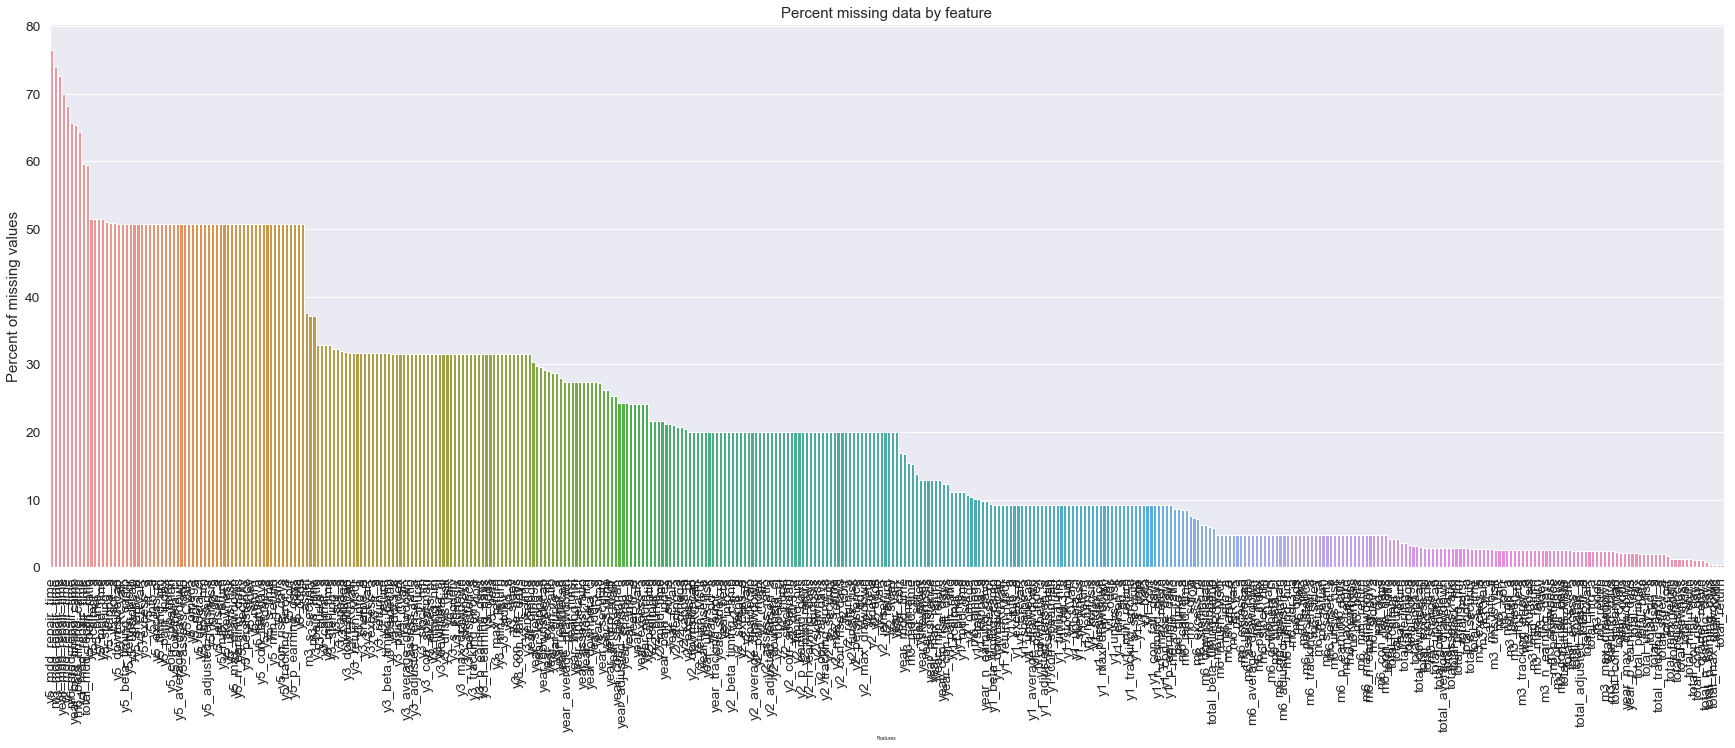

In [270]:
all_data_na = (df_merged[performance_features_cols].isnull().sum() / len(df_merged[performance_features_cols])) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()
if missing_data.size> 0:
    f, ax = plt.subplots(figsize=(30, 10))
    plt.xticks(rotation='90')
    sns.barplot(x=all_data_na.index, y=all_data_na)
    plt.xlabel('Features', fontsize=5)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    plt.show()

In [271]:
performance_features = missing_data[missing_data < 10 ].dropna()
print('# of performance features ',len(performance_features))

# of performance features  190


/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_75457/646116341.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


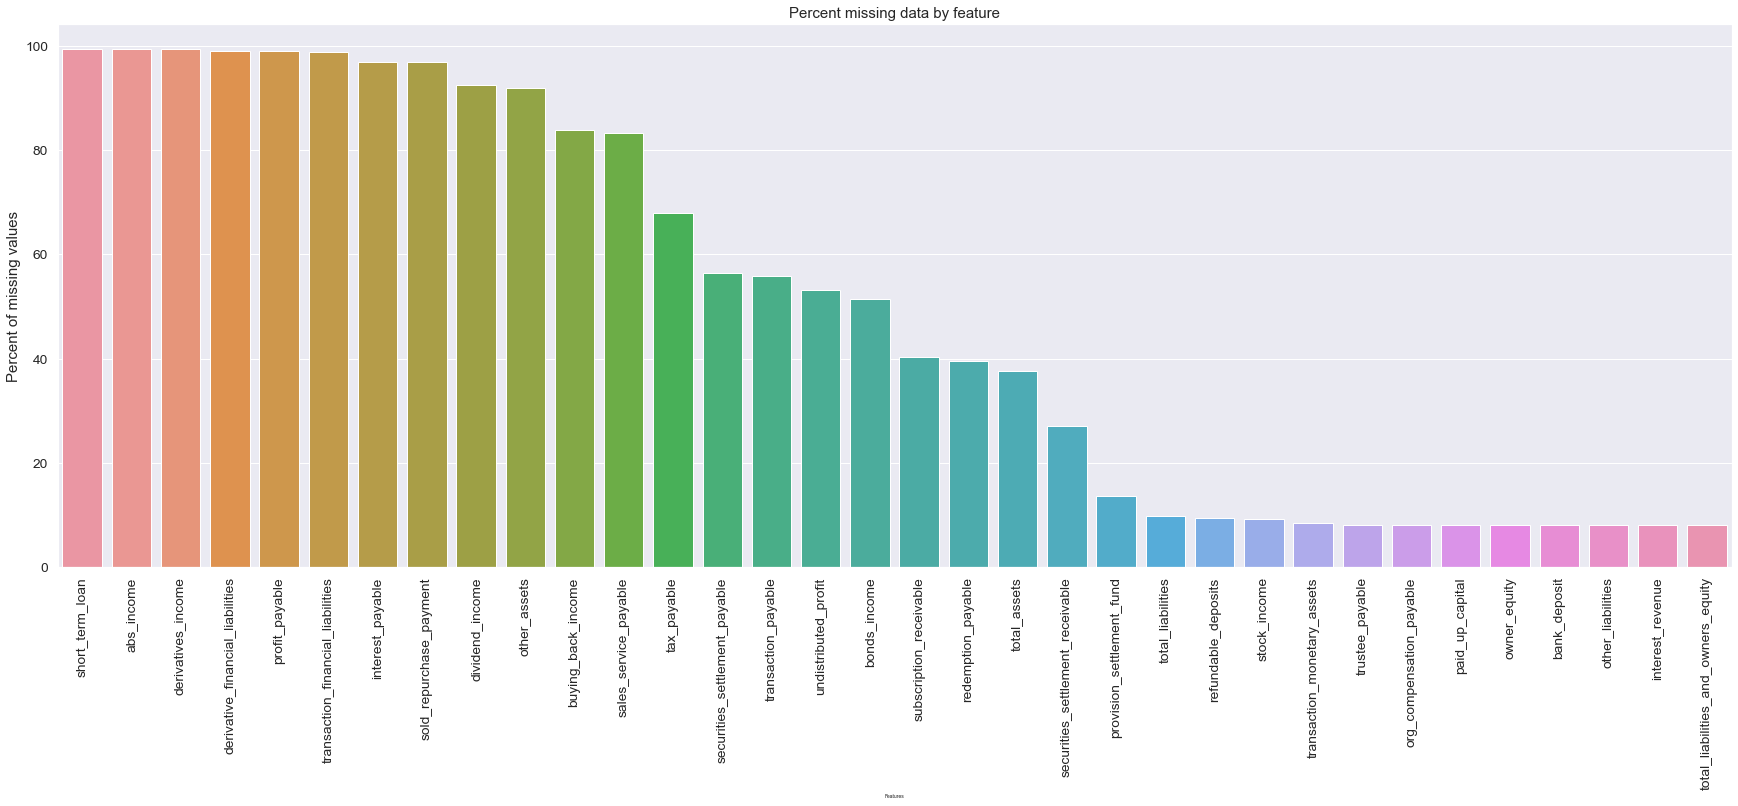

In [274]:
all_data_na = (df_merged[fundamental_features_cols].isnull().sum() / len(df_merged[fundamental_features_cols])) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()
if missing_data.size> 0:
    f, ax = plt.subplots(figsize=(30, 10))
    plt.xticks(rotation='90')
    sns.barplot(x=all_data_na.index, y=all_data_na)
    plt.xlabel('Features', fontsize=5)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    plt.show()

In [277]:
fundamental_features = missing_data[missing_data < 10 ].dropna()
print('# of fundamental features ',len(fundamental_features))

# of fundamental features  12


In [278]:
len(features)

205

In [283]:
features = ['ret','fee','asset'] + list(fundamental_features.index) + list(performance_features.index)

In [284]:
len(features)

205

In [451]:
data = df_merged[['statistic_date','fund_id']  + features ]

In [406]:
data.to_pickle('data.pickle')

##### This results in a total of 205 features

### EDA Analysis 

##### Correlation Plot (10 most correlated features)

In [287]:
corrmat = data.corr()

Text(0.5, 1.0, '1-Month return distrbution')

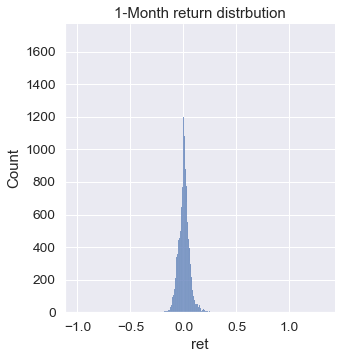

In [288]:
sns.displot(data.ret)
plt.title('1-Month return distrbution')


/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_75457/3644333460.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


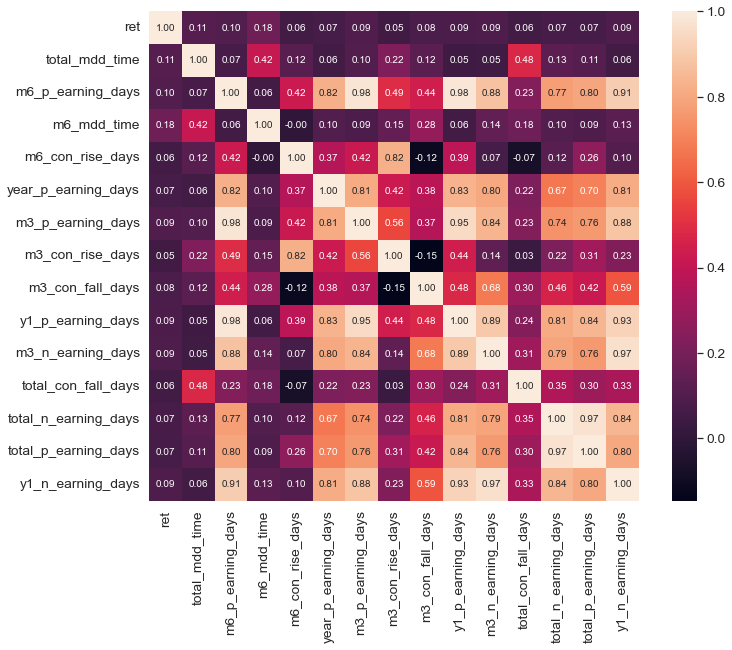

In [314]:
corrmat = data.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 9))
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ret')['ret'].index
cm = df_merged_filtered[cols].corr()
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [290]:
from pandas_profiling import ProfileReport

In [291]:
design_report = ProfileReport(df_merged_filtered[cols],explorative = True)

In [292]:
design_report.to_file('report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/charles/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Feature Normalization

##### Normalization / Demean

In [620]:
# data_records = []
# for col in tqdm(data.columns[2:]):
        
#     col_pivoted = pd.pivot_table(data=df_merged,index=['statistic_date'],columns= ['fund_id'],values=[col])
#     col_pivoted = col_pivoted.reindex(df_ret.index).ffill()
#     if col != 'ret':
#         col_pivoted_demean = (col_pivoted - col_pivoted.rolling(5).mean()) / col_pivoted.rolling(5).std()
#     else:
#         col_pivoted_demean = col_pivoted
#     #col_pivoted_demean_rank = col_pivoted_demean.rank(axis=1)
#     data_records.append(col_pivoted_demean)

##### Reconstruct DataFrame

In [621]:
# data_new = pd.pivot_table(df_combined.unstack().reset_index(),columns='level_0',values=0,index=['fund_id','statistic_date']).reset_index()